In [1]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [2]:
from surprise import Dataset, Reader, SVD, SVDpp, accuracy, KNNBasic
import pandas as pd
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import train_test_split
from tqdm import tqdm
import logging
import math
from scipy.optimize import curve_fit
import operator
from scipy.spatial.distance import jensenshannon
import json
import pickle as pickle
from itertools import chain, combinations
import sys

In [3]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
    
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


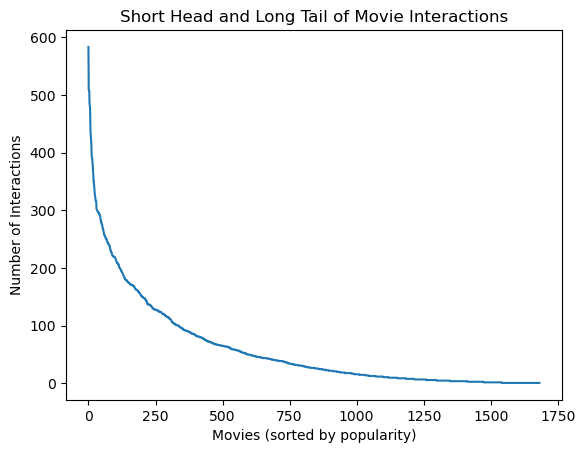

In [4]:
# Count ratings per movie and sort in descending order
movie_interactions = ratings['movieId'].value_counts().sort_values(ascending=False)

plt.plot(movie_interactions.values)
plt.title('Short Head and Long Tail of Movie Interactions')
plt.xlabel('Movies (sorted by popularity)')
plt.ylabel('Number of Interactions')
plt.show()


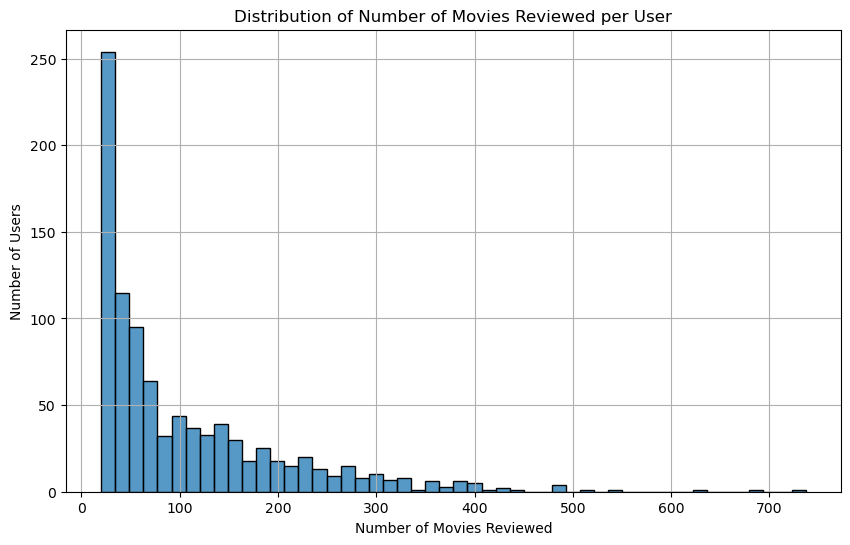

Number of users: 943


In [5]:
user_review_counts = ratings['userId'].value_counts()

plt.figure(figsize=(10, 6))
sns.histplot(user_review_counts, bins=50, kde=False)

plt.title('Distribution of Number of Movies Reviewed per User')
plt.xlabel('Number of Movies Reviewed')
plt.ylabel('Number of Users')
#plt.yscale('log') 
plt.grid(True)
plt.show()
print(f"Number of users: {ratings['userId'].nunique()}")


In [6]:
num_users = ratings['userId'].nunique()
num_items = ratings['movieId'].nunique()
num_interactions = len(ratings)

sparsity = 1 - (num_interactions / (num_users * num_items))
print(f"Sparsity of the dataset: {sparsity:.4f}")

Sparsity of the dataset: 0.9370


## SVD++ Model

In [7]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):

    # Map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, true_r) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    precision_avg = np.mean(list(precisions.values()))
    recall_avg = np.mean(list(recalls.values()))

    return precision_avg, recall_avg

In [8]:
def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.amin(array) < 0:
        # Values cannot be negative:
        array -= np.amin(array)
    # Values cannot be 0:
    #array += 0.0000001
    np.add(array, 0.0000001, out=array, casting="unsafe")
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

In [9]:
def calculate_gini_of_recommendations(predictions):
    # Count the number of recommendations for each movie
    recommendation_count = Counter([pred.iid for pred in predictions])
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [10]:
def arp_(users, recs, popularity):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        popularity_sum = 0
        for item in rec:
            p = popularity[int(item)]
            popularity_sum += p
        popularity_sum = popularity_sum/len(rec)
        users_sum += popularity_sum
    res = res * users_sum
    return res


In [11]:
def aplt(users, recs, long_tail):
    num_users = len(users)
    res = 1/num_users
    users_sum = 0
    for user in users:
        rec = recs[user]
        num_long_tail = len(set(long_tail).intersection(set(rec)))
        users_sum += num_long_tail/len(rec)
    res = res * users_sum
    return res

In [12]:
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    level=logging.INFO,
    handlers=[logging.StreamHandler()]
)

def split_by_week(df, start_date, end_date):
    train_df = df[(df['timestamp'] >= start_date) & (df['timestamp'] < end_date)]
    test_df = df[df['timestamp'] >= end_date]

    # Ensure that the test set contains only users and items from the train set
    test_df = test_df[test_df['userId'].isin(train_df['userId']) & test_df['movieId'].isin(train_df['movieId'])]

    reader = Reader(rating_scale=(1, 5))

    train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)

    trainset = train_data.build_full_trainset()

    testset = list(test_df[['userId', 'movieId', 'rating']].itertuples(index=False, name=None))
    

    return trainset, testset, train_df, test_df

In [13]:
def evaluate_over_weeks(ratings, num_weeks):
    results = []
    recommendations = []
    popularity = ratings['movieId'].value_counts(normalize=True).to_dict()  # Popularity based on rating counts
    #popularity = ratings['movieId'].value_counts().to_dict()
    max_popularity = max(popularity.values())
    popularity = {k: v / max_popularity for k, v in popularity.items()}
    
    long_tail_threshold = 0.2  # Define the long-tail threshold
    long_tail_items = [movie for movie, popularity in popularity.items() if popularity < long_tail_threshold]

    
    start_date = ratings['timestamp'].min()

    for week_n in range(1, num_weeks + 1):
        end_date = start_date + pd.DateOffset(weeks=1)
        logging.info(f"Processing week {week_n} ({start_date.date()} to {end_date.date()})...")
        
        trainset, testset, train_df, test_df = split_by_week(ratings, start_date, end_date)

        model = SVDpp()
        logging.info(f"Starting training for week {week_n}...")
        model.fit(trainset)
        logging.info(f"Training complete for week {week_n}.")

        predictions = model.test(testset)

        rmse = accuracy.rmse(predictions, verbose=False)
        precision, recall = precision_recall_at_k(predictions, k=10)
        gini_index = calculate_gini_of_recommendations(predictions)

        logging.info(f"Week {week_n} RMSE: {rmse:.4f}")

        active_users = train_df['userId'].unique()
        movie_ids = ratings['movieId'].unique()
        recs = {}  # Dictionary to store recommendations for each user

        logging.info(f"Generating recommendations for {len(active_users)} active users in week {week_n}...")
        for user_id in tqdm(active_users, desc=f"Recommending for week {week_n}"):
            user_recommendations = []

            for movie_id in movie_ids:
                if len(ratings[(ratings['userId'] == user_id) & (ratings['movieId'] == movie_id)]) == 0:
                    predicted_rating = model.predict(user_id, movie_id).est
                    user_recommendations.append((movie_id, predicted_rating))

            # Sort recommendations by predicted rating and take top 10
            top_recommendations = sorted(user_recommendations, key=lambda x: x[1], reverse=True)[:100]
            recs[user_id] = [rec[0] for rec in top_recommendations]

            # Extend recommendations for saving
            recommendations.extend([(user_id, rec[0], rec[1], week_n) for rec in top_recommendations])

        arp_value = arp_(active_users, recs, popularity)
        
        aplt_value = aplt(active_users, recs, long_tail_items)

        results.append({
            'week': week_n,
            'rmse': rmse,
            'num_active_users': len(active_users),
            'precision@10': precision,
            'recall@10': recall,
            'gini_index': gini_index,
            'arp': arp_value,
            'aplt': aplt_value,
        })

        start_date = end_date

    # Save original recommendations
    recommendations_df = pd.DataFrame(recommendations, columns=['userId', 'movieId', 'rating', 'week'])
    recommendations_df.to_csv("weekly_recommendations.csv", index=False)
    
    return results, recommendations_df


## Calibrated Popularity

In [14]:
def calib_rec_greedy(recs, alpha, k):
    reranked = []
    users=recs.userId.unique()

    for u in tqdm(users):
        #print("------------------------------------------------------")
        user_recs = recs.loc[recs['userId'] == u]
        user_recs = user_recs.drop_duplicates(subset=['movieId'])
        
        rating_dict = {}
        for index, row in user_recs.iterrows():
            rating_dict[row['movieId']] = row["rating"]

        #og user probabilities
        rated = UG_tolerance_map[u]

        #get all the items recommended for the user in ALS100
        items = user_recs.movieId.unique()

        T = items[:10]
        X = items[10:]

        old_list = items[:10]
        #print("User:", u, "; Original list:", old_list)
        new_list = items[:10]
        for index in range(1, 11):
            #print(index)
            #print("Old list:", old_list)
            delta = 0
            new_list = old_list.copy()
            init_cp = cp(old_list, rated, rating_dict, 0.9)
            #print("Init CP:", init_cp)
            for i in X:
                new_list[-index] = i
                new_cp = cp(new_list, rated, rating_dict, 0.9)
                #print("Item:", i, "\nNew list:", new_list, "\nCP score:", new_cp)
                if new_cp-init_cp>delta:
                    '''print("******************************")
                    print("Found better CP value!")
                    print("List:", new_list)
                    print("CP score:", new_cp)
                    print("******************************")'''
                    old_list = new_list.copy()
                    delta = new_cp-init_cp
            #print("=========================")


        #print("Best list candidate:", better_list)
        #reranked[u] = better_list
        for item in old_list:
            score = user_recs.loc[user_recs['movieId'] == item, 'rating'].item()
            #print("rating:", score)
            d = {'userId':u, 'movieId':item, 'rating':score}
            #print(d)
            reranked.append(d)

    return reranked

In [15]:
#=====================================================================
#METHODS
#method to categorize users into mainstream, niche and in-between
#takes original rating dataset as a parameter, returns a dict with user IDs and popularity group they belong to
def user_tol_cat(df):
    UG_map={}
    for u in users:
        UG1=[]
        UG2=[]
        UG3=[]
        rated=df[df.userId==u]['movieId']
        for i in rated:
            if i in G[0]:
                UG1.append(i)
            elif i in G[1]:
                UG2.append(i)
            else:
                UG3.append(i)
        UG_map[u]=[len(UG1),len(UG2),len(UG3)]

    UG_tolerance_map={}
    for u in users:
        u_g=UG_map[u]
        s=sum(u_g)
        UG_tolerance_map[u]=[float(x)/s for x in u_g]
    return UG_tolerance_map



# figure out what item index in an ordered list would be a cut-off point for a certain percentage
def find_short_head_split_point(sorted_list,percentage):
    s=0.0
    eightyPercent=float(sum(sorted_list))*percentage
    for i in range(len(sorted_list)):
        s+=sorted_list[i]
        if s>=eightyPercent:
            return i

# this method does the calculation magic - checks the relevance of the newly re-ranked list, as well as divergence between recommendation vector and user vector
def cp(recom, rated, rating_dict, alpha):

    UG_map=[len(set(G[0]).intersection(set(recom))),len(set(G[1]).intersection(set(recom))),len(set(G[2]).intersection(set(recom)))]
    UG_map = [float(x)/10 for x in UG_map]

    relevance_sum = 0
    for i in recom:
        rating = rating_dict[i]
        relevance_sum += rating

    left = (1-alpha)*relevance_sum
    j = jensenshannon(rated,UG_map)
    right = alpha*j
    res = left-right
    return res

def cali(recs100, alpha, k, week):
    print(f"Adding 'week' column for week {week}...")
    recs100['week'] = week  
    print("Checking recs100 before reranking:")
    print(recs100.head())  

    print("####### Starting the reranking...")
    reranked = calib_rec_greedy(recs100, alpha, k)
    
    # Check if reranked is a DataFrame, if not, convert it to one
    if not isinstance(reranked, pd.DataFrame):
        reranked = pd.DataFrame(reranked, columns=['userId', 'movieId', 'rating'])

    print("Checking reranked DataFrame:")
    print(reranked.head())  # Check if 'week' column is still there
    
    reranked['week'] = week  # Add the 'week' column manually here
    print("Checking reranked DataFrame after adding 'week':")
    print(reranked.head())

    reranked.to_csv(res_path, index=False)
    return reranked


In [16]:
alpha = 0.9
k = 10

# list of user IDs for utility
users = []
res_path = "svd_re-ranking"

In [17]:
# save a list of user IDs in a utility variable we have above for future use, it will come handy
users=ratings.userId.unique()

# calculate item popularities in the original rating dataset
item_pops=ratings.groupby('movieId').size()/len(ratings.userId.unique())
#item_pops.head()
item_pops_total=ratings.groupby('movieId').size()

sorted_item_pops_map = sorted(item_pops_total.items(),reverse=True,key=operator.itemgetter(1))
sorted_items=[x[0] for x in sorted_item_pops_map]
sorted_ratio=[x[1] for x in sorted_item_pops_map]

# find out where are the thresholds between head and mid items, mid and tail items
short_head_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.2)
mid_tail_point=find_short_head_split_point(sorted(item_pops,reverse=True),0.8)

# put items into separate popularity groups
indexes=[short_head_point,mid_tail_point,len(item_pops)]
global G
G =[]
s=0
for i in range(len(indexes)):
    G.append([x[0] for x in sorted_item_pops_map[s:int(indexes[i])]])
    s=int(indexes[i])
G_names=[]
for i in range(len(G)):
    G_names.append("G%s"%(i+1))

# just double checking the lists of items with different popularites
print("Lengths of G lists:")
for l in G:
    print(len(l))

# now we can split the users into different groups based on their popularity preference too
# we will need the original rating dataset for this too
print("Calculating original user tolerance map...")
global UG_tolerance_map
UG_tolerance_map=user_tol_cat(ratings)

Lengths of G lists:
58
477
1147
Calculating original user tolerance map...


In [18]:
# Convert to a list of tolerance distributions
tolerances = list(UG_tolerance_map.values())

# Convert to a NumPy array for easier analysis
tolerance_array = np.array(tolerances)

# Calculate mean tolerance for each category (e.g., Head, Mid, Tail)
mean_tolerance = tolerance_array.mean(axis=0)
print(f"Mean tolerance: {mean_tolerance}")

# Check variance or standard deviation
std_tolerance = tolerance_array.std(axis=0)
print(f"Standard deviation: {std_tolerance}")

Mean tolerance: [0.25545736 0.58042645 0.16411619]
Standard deviation: [0.10885524 0.08825771 0.10299894]


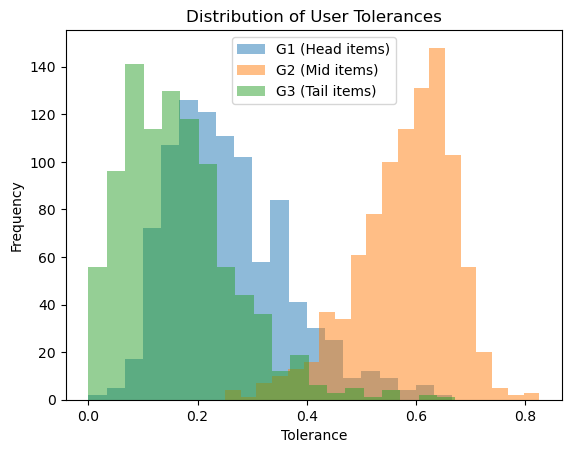

In [19]:
# Create separate lists for each category (e.g., G1, G2, G3)
g1, g2, g3 = tolerance_array.T  # Transpose to split into groups

# Plot histograms for each category
plt.hist(g1, bins=20, alpha=0.5, label="G1 (Head items)")
plt.hist(g2, bins=20, alpha=0.5, label="G2 (Mid items)")
plt.hist(g3, bins=20, alpha=0.5, label="G3 (Tail items)")

plt.title("Distribution of User Tolerances")
plt.xlabel("Tolerance")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Running the model

In [20]:
if __name__ == "__main__":    
    num_weeks = 25
    weekly_results, recommendations_df = evaluate_over_weeks(ratings, num_weeks)

    # Loop over each week and apply CP re-ranking
    all_reranked_recommendations = []
    for week in range(1, num_weeks + 1):
        print(f"Processing week {week}...")
        weekly_recommendations = recommendations_df[recommendations_df['week'] == week]  # Filter recommendations for the week
        
        print(f"Checking weekly recommendations for week {week}:")
        print(weekly_recommendations.head())  # Verify 'week' column exists here

        logging.info(f"Applying CP re-ranking for week {week}...")
        reranked_recommendations = cali(weekly_recommendations, alpha, k, week)

        # Add to the list of reranked recommendations
        all_reranked_recommendations.append(reranked_recommendations)

    # Combine all reranked recommendations into a single DataFrame
    reranked_df = pd.concat(all_reranked_recommendations, ignore_index=True)

    # Check if the 'week' column is preserved in the final DataFrame
    print("Checking final reranked_df:")
    print(reranked_df.head())

    reranked_df.to_csv("weekly_reranked_recommendations.csv", index=False)

    print(pd.DataFrame(weekly_results))

2024-12-10 18:48:04,538 - Processing week 1 (1997-09-20 to 1997-09-27)...
2024-12-10 18:48:04,545 - Starting training for week 1...
2024-12-10 18:48:04,875 - Training complete for week 1.
2024-12-10 18:48:04,984 - Week 1 RMSE: 1.1011
2024-12-10 18:48:04,985 - Generating recommendations for 57 active users in week 1...
Recommending for week 1: 100%|██████████████████| 57/57 [00:20<00:00,  2.82it/s]
2024-12-10 18:48:25,191 - Processing week 2 (1997-09-27 to 1997-10-04)...
2024-12-10 18:48:25,198 - Starting training for week 2...
2024-12-10 18:48:25,338 - Training complete for week 2.
2024-12-10 18:48:25,391 - Week 2 RMSE: 1.1017
2024-12-10 18:48:25,393 - Generating recommendations for 59 active users in week 2...
Recommending for week 2: 100%|██████████████████| 59/59 [00:20<00:00,  2.88it/s]
2024-12-10 18:48:45,855 - Processing week 3 (1997-10-04 to 1997-10-11)...
2024-12-10 18:48:45,861 - Starting training for week 3...
2024-12-10 18:48:46,007 - Training complete for week 3.
2024-12-10

2024-12-10 18:55:40,041 - Training complete for week 21.
2024-12-10 18:55:40,055 - Week 21 RMSE: 0.9628
2024-12-10 18:55:40,056 - Generating recommendations for 50 active users in week 21...
Recommending for week 21: 100%|█████████████████| 50/50 [00:16<00:00,  3.01it/s]
2024-12-10 18:55:56,675 - Processing week 22 (1998-02-14 to 1998-02-21)...
2024-12-10 18:55:56,679 - Starting training for week 22...
2024-12-10 18:55:56,978 - Training complete for week 22.
2024-12-10 18:55:57,020 - Week 22 RMSE: 0.9073
2024-12-10 18:55:57,021 - Generating recommendations for 54 active users in week 22...
Recommending for week 22: 100%|█████████████████| 54/54 [00:18<00:00,  2.95it/s]
2024-12-10 18:56:15,307 - Processing week 23 (1998-02-21 to 1998-02-28)...
2024-12-10 18:56:15,312 - Starting training for week 23...
2024-12-10 18:56:15,565 - Training complete for week 23.
2024-12-10 18:56:15,583 - Week 23 RMSE: 1.1079
2024-12-10 18:56:15,583 - Generating recommendations for 78 active users in week 23.

User 299, Average Popularity: 0.20192109777015435
User 286, Average Popularity: 0.2013893653516295
User 219, Average Popularity: 0.27996569468267585
User 294, Average Popularity: 0.226106346483705
User 64, Average Popularity: 0.15210977701543738
User 235, Average Popularity: 0.2673927958833619
User 164, Average Popularity: 0.2757632933104631
User 1, Average Popularity: 0.1927958833619211
User 279, Average Popularity: 0.24644939965694682
User 120, Average Popularity: 0.2893138936535163
User 319, Average Popularity: 0.31602058319039456
User 228, Average Popularity: 0.2814065180102916
User 344, Average Popularity: 0.19615780445969122
User 368, Average Popularity: 0.22174957118353344
User 14, Average Popularity: 0.23921097770154373
User 60, Average Popularity: 0.23864493996569472
User 378, Average Popularity: 0.16492281303602063
User 369, Average Popularity: 0.3019725557461406
User 13, Average Popularity: 0.11958833619210978
User 393, Average Popularity: 0.17816466552315607
User 408, Avera

100%|███████████████████████████████████████████| 57/57 [00:01<00:00, 40.07it/s]
2024-12-10 18:57:24,253 - Applying CP re-ranking for week 2...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     291      603  5.000000
1     291       23  5.000000
2     291      408  5.000000
3     291      127  5.000000
4     291     1149  4.636296
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     291      603  5.000000     1
1     291       23  5.000000     1
2     291      408  5.000000     1
3     291      127  5.000000     1
4     291     1149  4.636296     1
Processing week 2...
Checking weekly recommendations for week 2:
      userId  movieId    rating  week
5700      63      127  4.284103     2
5701      63      174  4.094947     2
5702      63      173  3.899027     2
5703      63       64  3.884968     2
5704      63      433  3.842980     2
Adding 'week' column for week 2...
Checking recs100 before reranking:
      userId  movieId    rating  week
5700      63      127  4.284103     2
5701      63      174  4.094947     2
5702      63      173  3.899027     2
5703      63       64  

100%|███████████████████████████████████████████| 59/59 [00:01<00:00, 37.99it/s]
2024-12-10 18:57:25,813 - Applying CP re-ranking for week 3...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0      63      127  4.284103
1      63      174  4.094947
2      63      173  3.899027
3      63     1194  3.496423
4      63      433  3.842980
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0      63      127  4.284103     2
1      63      174  4.094947     2
2      63      173  3.899027     2
3      63     1194  3.496423     2
4      63      433  3.842980     2
Processing week 3...
Checking weekly recommendations for week 3:
       userId  movieId    rating  week
11600     200       64  4.945503     3
11601     200      511  4.883990     3
11602     200      180  4.861049     3
11603     200      203  4.768106     3
11604     200      408  4.736775     3
Adding 'week' column for week 3...
Checking recs100 before reranking:
       userId  movieId    rating  week
11600     200       64  4.945503     3
11601     200      511  4.883990     3
11602     200      180  4.861049     3
11603     200

100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 38.56it/s]
2024-12-10 18:57:27,376 - Applying CP re-ranking for week 4...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     200       64  4.945503
1     200      511  4.883990
2     200      180  4.861049
3     200      203  4.768106
4     200      408  4.736775
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     200       64  4.945503     3
1     200      511  4.883990     3
2     200      180  4.861049     3
3     200      203  4.768106     3
4     200      408  4.736775     3
Processing week 4...
Checking weekly recommendations for week 4:
       userId  movieId    rating  week
17600     160      181  5.000000     4
17601     160      172  5.000000     4
17602     160       12  4.841768     4
17603     160       22  4.696089     4
17604     160      651  4.655758     4
Adding 'week' column for week 4...
Checking recs100 before reranking:
       userId  movieId    rating  week
17600     160      181  5.000000     4
17601     160      172  5.000000     4
17602     160       12  4.841768     4
17603     160

100%|███████████████████████████████████████████| 57/57 [00:01<00:00, 39.81it/s]
2024-12-10 18:57:28,813 - Applying CP re-ranking for week 5...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     160      181  5.000000
1     160      172  5.000000
2     160      114  4.537154
3     160      196  4.507953
4     160      651  4.655758
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     160      181  5.000000     4
1     160      172  5.000000     4
2     160      114  4.537154     4
3     160      196  4.507953     4
4     160      651  4.655758     4
Processing week 5...
Checking weekly recommendations for week 5:
       userId  movieId    rating  week
23300     162      258  4.192522     5
23301     162       98  4.125994     5
23302     162      357  4.096445     5
23303     162      100  4.065266     5
23304     162       19  4.028156     5
Adding 'week' column for week 5...
Checking recs100 before reranking:
       userId  movieId    rating  week
23300     162      258  4.192522     5
23301     162       98  4.125994     5
23302     162      357  4.096445     5
23303     162

100%|███████████████████████████████████████████| 48/48 [00:01<00:00, 39.17it/s]
2024-12-10 18:57:30,045 - Applying CP re-ranking for week 6...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     162      258  4.192522
1     162       98  4.125994
2     162      357  4.096445
3     162      100  4.065266
4     162       19  4.028156
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     162      258  4.192522     5
1     162       98  4.125994     5
2     162      357  4.096445     5
3     162      100  4.065266     5
4     162       19  4.028156     5
Processing week 6...
Checking weekly recommendations for week 6:
       userId  movieId    rating  week
28100     299      589  4.366401     6
28101     299       64  4.296411     6
28102     299       69  4.132958     6
28103     299       79  4.105738     6
28104     299      357  4.075084     6
Adding 'week' column for week 6...
Checking recs100 before reranking:
       userId  movieId    rating  week
28100     299      589  4.366401     6
28101     299       64  4.296411     6
28102     299       69  4.132958     6
28103     299

100%|███████████████████████████████████████████| 45/45 [00:01<00:00, 38.78it/s]
2024-12-10 18:57:31,210 - Applying CP re-ranking for week 7...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     299      589  4.366401
1     299       64  4.296411
2     299      273  3.952611
3     299      268  3.938791
4     299      993  3.947293
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     299      589  4.366401     6
1     299       64  4.296411     6
2     299      273  3.952611     6
3     299      268  3.938791     6
4     299      993  3.947293     6
Processing week 7...
Checking weekly recommendations for week 7:
       userId  movieId    rating  week
32600      22      156  4.809972     7
32601      22      136  4.695792     7
32602      22      483  4.599199     7
32603      22       57  4.575484     7
32604      22      302  4.550695     7
Adding 'week' column for week 7...
Checking recs100 before reranking:
       userId  movieId    rating  week
32600      22      156  4.809972     7
32601      22      136  4.695792     7
32602      22      483  4.599199     7
32603      22

100%|███████████████████████████████████████████| 43/43 [00:01<00:00, 39.66it/s]
2024-12-10 18:57:32,301 - Applying CP re-ranking for week 8...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0      22      156  4.809972
1      22      136  4.695792
2      22      483  4.599199
3      22       57  4.575484
4      22      302  4.550695
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0      22      156  4.809972     7
1      22      136  4.695792     7
2      22      483  4.599199     7
3      22       57  4.575484     7
4      22      302  4.550695     7
Processing week 8...
Checking weekly recommendations for week 8:
       userId  movieId    rating  week
36900      62      408  4.405452     8
36901      62      169  4.354036     8
36902      62      177  4.229244     8
36903      62      194  4.225384     8
36904      62       48  4.219327     8
Adding 'week' column for week 8...
Checking recs100 before reranking:
       userId  movieId    rating  week
36900      62      408  4.405452     8
36901      62      169  4.354036     8
36902      62      177  4.229244     8
36903      62

 41%|█████████████████▎                        | 52/126 [00:01<00:01, 39.53it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|█████████████████████████████████████████| 126/126 [00:03<00:00, 40.05it/s]
2024-12-10 18:57:35,457 - Applying CP re-ranking for week 9...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0      62      408  4.405452
1      62      169  4.354036
2      62      177  4.229244
3      62      194  4.225384
4      62       48  4.219327
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0      62      408  4.405452     8
1      62      169  4.354036     8
2      62      177  4.229244     8
3      62      194  4.225384     8
4      62       48  4.219327     8
Processing week 9...
Checking weekly recommendations for week 9:
       userId  movieId    rating  week
49500     286      474  4.658089     9
49501     286      493  4.613781     9
49502     286      511  4.581606     9
49503     286       12  4.541832     9
49504     286       64  4.537136     9
Adding 'week' column for week 9...
Checking recs100 before reranking:
       userId  movieId    rating  week
49500     286      474  4.658089     9
49501     286      493  4.613781     9
49502     286      511  4.581606     9
49503     286

100%|█████████████████████████████████████████| 104/104 [00:02<00:00, 40.13it/s]
2024-12-10 18:57:38,056 - Applying CP re-ranking for week 10...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     286      474  4.658089
1     286      493  4.613781
2     286      511  4.581606
3     286       12  4.541832
4     286      613  4.368065
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     286      474  4.658089     9
1     286      493  4.613781     9
2     286      511  4.581606     9
3     286       12  4.541832     9
4     286      613  4.368065     9
Processing week 10...
Checking weekly recommendations for week 10:
       userId  movieId    rating  week
59900     244      127  4.652972    10
59901     244      129  4.608354    10
59902     244      194  4.543202    10
59903     244      423  4.534075    10
59904     244      223  4.518305    10
Adding 'week' column for week 10...
Checking recs100 before reranking:
       userId  movieId    rating  week
59900     244      127  4.652972    10
59901     244      129  4.608354    10
59902     244      194  4.543202    10
59903     

100%|███████████████████████████████████████████| 72/72 [00:01<00:00, 38.50it/s]
2024-12-10 18:57:39,933 - Applying CP re-ranking for week 11...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     244      127  4.652972
1     244      129  4.608354
2     244      194  4.543202
3     244      963  4.401328
4     244      223  4.518305
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     244      127  4.652972    10
1     244      129  4.608354    10
2     244      194  4.543202    10
3     244      963  4.401328    10
4     244      223  4.518305    10
Processing week 11...
Checking weekly recommendations for week 11:
       userId  movieId    rating  week
67100     196      357  4.533575    11
67101     196       64  4.397238    11
67102     196      603  4.272541    11
67103     196       98  4.238608    11
67104     196       14  4.174367    11
Adding 'week' column for week 11...
Checking recs100 before reranking:
       userId  movieId    rating  week
67100     196      357  4.533575    11
67101     196       64  4.397238    11
67102     196      603  4.272541    11
67103     

100%|███████████████████████████████████████████| 79/79 [00:02<00:00, 36.80it/s]
2024-12-10 18:57:42,089 - Applying CP re-ranking for week 12...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     196      357  4.533575
1     196       64  4.397238
2     196      603  4.272541
3     196     1194  3.931718
4     196       14  4.174367
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     196      357  4.533575    11
1     196       64  4.397238    11
2     196      603  4.272541    11
3     196     1194  3.931718    11
4     196       14  4.174367    11
Processing week 12...
Checking weekly recommendations for week 12:
       userId  movieId    rating  week
75000      28      192  4.479746    12
75001      28      168  4.436789    12
75002      28      922  4.415951    12
75003      28      512  4.367492    12
75004      28       64  4.357139    12
Adding 'week' column for week 12...
Checking recs100 before reranking:
       userId  movieId    rating  week
75000      28      192  4.479746    12
75001      28      168  4.436789    12
75002      28      922  4.415951    12
75003     

100%|███████████████████████████████████████████| 44/44 [00:01<00:00, 37.93it/s]
2024-12-10 18:57:43,256 - Applying CP re-ranking for week 13...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0      28      192  4.479746
1      28      168  4.436789
2      28      922  4.415951
3      28      652  4.216989
4      28       64  4.357139
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0      28      192  4.479746    12
1      28      168  4.436789    12
2      28      922  4.415951    12
3      28      652  4.216989    12
4      28       64  4.357139    12
Processing week 13...
Checking weekly recommendations for week 13:
       userId  movieId    rating  week
79400     301     1039  4.351045    13
79401     301      234  4.289550    13
79402     301      170  4.280670    13
79403     301      285  4.274367    13
79404     301      169  4.265342    13
Adding 'week' column for week 13...
Checking recs100 before reranking:
       userId  movieId    rating  week
79400     301     1039  4.351045    13
79401     301      234  4.289550    13
79402     301      170  4.280670    13
79403     

100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 38.58it/s]
2024-12-10 18:57:44,661 - Applying CP re-ranking for week 14...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     301     1039  4.351045
1     301      234  4.289550
2     301      170  4.280670
3     301      285  4.274367
4     301      169  4.265342
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     301     1039  4.351045    13
1     301      234  4.289550    13
2     301      170  4.280670    13
3     301      285  4.274367    13
4     301      169  4.265342    13
Processing week 14...
Checking weekly recommendations for week 14:
       userId  movieId    rating  week
84800     178      408  4.786820    14
84801     178      151  4.714100    14
84802     178       14  4.696244    14
84803     178      132  4.647552    14
84804     178      515  4.564759    14
Adding 'week' column for week 14...
Checking recs100 before reranking:
       userId  movieId    rating  week
84800     178      408  4.786820    14
84801     178      151  4.714100    14
84802     178       14  4.696244    14
84803     

100%|███████████████████████████████████████████| 49/49 [00:01<00:00, 38.35it/s]
2024-12-10 18:57:45,947 - Applying CP re-ranking for week 15...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     178      408  4.786820
1     178      151  4.714100
2     178       14  4.696244
3     178      132  4.647552
4     178      515  4.564759
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     178      408  4.786820    14
1     178      151  4.714100    14
2     178       14  4.696244    14
3     178      132  4.647552    14
4     178      515  4.564759    14
Processing week 15...
Checking weekly recommendations for week 15:
       userId  movieId    rating  week
89700       6      114  4.521002    15
89701       6      313  4.393550    15
89702       6      150  4.316740    15
89703       6      270  4.313279    15
89704       6      434  4.264800    15
Adding 'week' column for week 15...
Checking recs100 before reranking:
       userId  movieId    rating  week
89700       6      114  4.521002    15
89701       6      313  4.393550    15
89702       6      150  4.316740    15
89703     

100%|███████████████████████████████████████████| 74/74 [00:01<00:00, 39.38it/s]
2024-12-10 18:57:47,834 - Applying CP re-ranking for week 16...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0       6      114  4.521002
1       6      313  4.393550
2       6      150  4.316740
3       6      270  4.313279
4       6      434  4.264800
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0       6      114  4.521002    15
1       6      313  4.393550    15
2       6      150  4.316740    15
3       6      270  4.313279    15
4       6      434  4.264800    15
Processing week 16...
Checking weekly recommendations for week 16:
       userId  movieId    rating  week
97100     298       56  5.000000    16
97101     298      313  4.800233    16
97102     298       89  4.746675    16
97103     298       12  4.693162    16
97104     298      176  4.628939    16
Adding 'week' column for week 16...
Checking recs100 before reranking:
       userId  movieId    rating  week
97100     298       56  5.000000    16
97101     298      313  4.800233    16
97102     298       89  4.746675    16
97103     

100%|███████████████████████████████████████████| 83/83 [00:02<00:00, 39.76it/s]
2024-12-10 18:57:49,929 - Applying CP re-ranking for week 17...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     298       56  5.000000
1     298      313  4.800233
2     298       89  4.746675
3     298      169  4.480023
4     298       26  4.486575
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     298       56  5.000000    16
1     298      313  4.800233    16
2     298       89  4.746675    16
3     298      169  4.480023    16
4     298       26  4.486575    16
Processing week 17...
Checking weekly recommendations for week 17:
        userId  movieId    rating  week
105400     246      302  4.748903    17
105401     246      298  4.284580    17
105402     246      268  4.216699    17
105403     246      114  4.184014    17
105404     246      648  4.154086    17
Adding 'week' column for week 17...
Checking recs100 before reranking:
        userId  movieId    rating  week
105400     246      302  4.748903    17
105401     246      298  4.284580    17
105402     246      268  4.216699    17


 62%|██████████████████████████▋                | 46/74 [00:01<00:00, 39.84it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████████| 74/74 [00:01<00:00, 39.64it/s]
2024-12-10 18:57:51,802 - Applying CP re-ranking for week 18...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     246      302  4.748903
1     246      298  4.284580
2     246      268  4.216699
3     246      114  4.184014
4     246      648  4.154086
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     246      302  4.748903    17
1     246      298  4.284580    17
2     246      268  4.216699    17
3     246      114  4.184014    17
4     246      648  4.154086    17
Processing week 18...
Checking weekly recommendations for week 18:
        userId  movieId    rating  week
112800     284       50  4.233622    18
112801     284      172  4.218324    18
112802     284       22  4.148242    18
112803     284       98  4.060598    18
112804     284       79  4.022744    18
Adding 'week' column for week 18...
Checking recs100 before reranking:
        userId  movieId    rating  week
112800     284       50  4.233622    18
112801     284      172  4.218324    18
112802     284       22  4.148242    18


100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 39.16it/s]
2024-12-10 18:57:53,340 - Applying CP re-ranking for week 19...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     284       50  4.233622
1     284      172  4.218324
2     284        8  3.880148
3     284      731  3.788728
4     284      689  3.895266
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     284       50  4.233622    18
1     284      172  4.218324    18
2     284        8  3.880148    18
3     284      731  3.788728    18
4     284      689  3.895266    18
Processing week 19...
Checking weekly recommendations for week 19:
        userId  movieId    rating  week
118800     119      302  4.824448    19
118801     119      211  4.687499    19
118802     119       98  4.563600    19
118803     119      127  4.557644    19
118804     119      478  4.540087    19
Adding 'week' column for week 19...
Checking recs100 before reranking:
        userId  movieId    rating  week
118800     119      302  4.824448    19
118801     119      211  4.687499    19
118802     119       98  4.563600    19


100%|███████████████████████████████████████████| 67/67 [00:01<00:00, 39.63it/s]
2024-12-10 18:57:55,037 - Applying CP re-ranking for week 20...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     119      302  4.824448
1     119      211  4.687499
2     119       98  4.563600
3     119      686  4.354430
4     119      478  4.540087
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     119      302  4.824448    19
1     119      211  4.687499    19
2     119       98  4.563600    19
3     119      686  4.354430    19
4     119      478  4.540087    19
Processing week 20...
Checking weekly recommendations for week 20:
        userId  movieId    rating  week
125500     166       50  4.384550    20
125501     166      127  4.347252    20
125502     166      172  4.242708    20
125503     166      709  4.225301    20
125504     166      923  4.221197    20
Adding 'week' column for week 20...
Checking recs100 before reranking:
        userId  movieId    rating  week
125500     166       50  4.384550    20
125501     166      127  4.347252    20
125502     166      172  4.242708    20


100%|███████████████████████████████████████████| 63/63 [00:01<00:00, 40.60it/s]
2024-12-10 18:57:56,595 - Applying CP re-ranking for week 21...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     166       50  4.384550
1     166      127  4.347252
2     166      172  4.242708
3     166      709  4.225301
4     166      923  4.221197
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     166       50  4.384550    20
1     166      127  4.347252    20
2     166      172  4.242708    20
3     166      709  4.225301    20
4     166      923  4.221197    20
Processing week 21...
Checking weekly recommendations for week 21:
        userId  movieId    rating  week
131800     157       64  4.233407    21
131801     157       97  4.225194    21
131802     157      237  4.194266    21
131803     157       79  4.187240    21
131804     157       88  4.135800    21
Adding 'week' column for week 21...
Checking recs100 before reranking:
        userId  movieId    rating  week
131800     157       64  4.233407    21
131801     157       97  4.225194    21
131802     157      237  4.194266    21


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 39.90it/s]
2024-12-10 18:57:57,854 - Applying CP re-ranking for week 22...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     157       64  4.233407
1     157       97  4.225194
2     157      237  4.194266
3     157       79  4.187240
4     157       88  4.135800
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     157       64  4.233407    21
1     157       97  4.225194    21
2     157      237  4.194266    21
3     157       79  4.187240    21
4     157       88  4.135800    21
Processing week 22...
Checking weekly recommendations for week 22:
        userId  movieId    rating  week
136800     308      173  4.368061    22
136801     308     1131  4.252130    22
136802     308      896  4.246662    22
136803     308      272  4.197619    22
136804     308      340  4.194570    22
Adding 'week' column for week 22...
Checking recs100 before reranking:
        userId  movieId    rating  week
136800     308      173  4.368061    22
136801     308     1131  4.252130    22
136802     308      896  4.246662    22


 72%|███████████████████████████████            | 39/54 [00:00<00:00, 40.78it/s]/Users/bjornmorch/anaconda3/lib/python3.11/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 40.61it/s]
2024-12-10 18:57:59,189 - Applying CP re-ranking for week 23...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     308      173  4.368061
1     308     1131  4.252130
2     308      896  4.246662
3     308      272  4.197619
4     308      340  4.194570
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     308      173  4.368061    22
1     308     1131  4.252130    22
2     308      896  4.246662    22
3     308      272  4.197619    22
4     308      340  4.194570    22
Processing week 23...
Checking weekly recommendations for week 23:
        userId  movieId    rating  week
142200     224      127  4.067913    23
142201     224      195  4.061199    23
142202     224       64  4.048780    23
142203     224      302  4.041153    23
142204     224      174  4.040793    23
Adding 'week' column for week 23...
Checking recs100 before reranking:
        userId  movieId    rating  week
142200     224      127  4.067913    23
142201     224      195  4.061199    23
142202     224       64  4.048780    23


100%|███████████████████████████████████████████| 78/78 [00:01<00:00, 40.56it/s]
2024-12-10 18:58:01,118 - Applying CP re-ranking for week 24...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     224      127  4.067913
1     224      963  3.612567
2     224       87  3.787333
3     224      179  3.803459
4     224      355  3.673070
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     224      127  4.067913    23
1     224      963  3.612567    23
2     224       87  3.787333    23
3     224      179  3.803459    23
4     224      355  3.673070    23
Processing week 24...
Checking weekly recommendations for week 24:
        userId  movieId    rating  week
150000     293      169  4.389999    24
150001     293      736  4.279560    24
150002     293      604  4.227818    24
150003     293       42  4.221414    24
150004     293      242  4.151420    24
Adding 'week' column for week 24...
Checking recs100 before reranking:
        userId  movieId    rating  week
150000     293      169  4.389999    24
150001     293      736  4.279560    24
150002     293      604  4.227818    24


100%|███████████████████████████████████████████| 65/65 [00:01<00:00, 40.69it/s]
2024-12-10 18:58:02,722 - Applying CP re-ranking for week 25...
/var/folders/gd/pkxntl9133g1q267dt_5zdr80000gn/T/ipykernel_66060/1010131086.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recs100['week'] = week


Checking reranked DataFrame:
   userId  movieId    rating
0     293      169  4.389999
1     293      736  4.279560
2     293      604  4.227818
3     293       42  4.221414
4     293      242  4.151420
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     293      169  4.389999    24
1     293      736  4.279560    24
2     293      604  4.227818    24
3     293       42  4.221414    24
4     293      242  4.151420    24
Processing week 25...
Checking weekly recommendations for week 25:
        userId  movieId    rating  week
156500     299      316  4.150504    25
156501     299      315  4.128869    25
156502     299      344  4.045374    25
156503     299       64  4.029061    25
156504     299      183  3.971727    25
Adding 'week' column for week 25...
Checking recs100 before reranking:
        userId  movieId    rating  week
156500     299      316  4.150504    25
156501     299      315  4.128869    25
156502     299      344  4.045374    25


100%|███████████████████████████████████████████| 54/54 [00:01<00:00, 40.77it/s]

Checking reranked DataFrame:
   userId  movieId    rating
0     299      316  4.150504
1     299      315  4.128869
2     299      344  4.045374
3     299       64  4.029061
4     299        8  3.916163
Checking reranked DataFrame after adding 'week':
   userId  movieId    rating  week
0     299      316  4.150504    25
1     299      315  4.128869    25
2     299      344  4.045374    25
3     299       64  4.029061    25
4     299        8  3.916163    25
Checking final reranked_df:
   userId  movieId    rating  week
0     291      603  5.000000     1
1     291       23  5.000000     1
2     291      408  5.000000     1
3     291      127  5.000000     1
4     291     1149  4.636296     1
    week      rmse  num_active_users  precision@10  recall@10  gini_index  \
0      1  1.101085                57      0.705208   0.319664    0.379338   
1      2  1.101659                59      0.661427   0.277571    0.380783   
2      3  1.004407                60      0.693669   0.384533    0.38

In [21]:
reranked_df.head()

,userId,movieId,rating,week
0,291,603,5.000000,1
1,291,23,5.000000,1
2,291,408,5.000000,1
3,291,127,5.000000,1
4,291,1149,4.636296,1


In [22]:
for result in weekly_results:
    print(f"Week {result['week']}: RMSE = {result['rmse']:.4f} - Precision@10: {result['precision@10']:.4f}, "
          f"Recall@10: {result['recall@10']:.4f}, Active Users = {result['num_active_users']}, "
          f"Gini Index of Recommendations = {result['gini_index']:.4f}, "
          f"ARP = {result['arp']:.4f}, "
          f"APLT = {result['aplt']:.4f}") 

Week 1: RMSE = 1.1011 - Precision@10: 0.7052, Recall@10: 0.3197, Active Users = 57, Gini Index of Recommendations = 0.3793, ARP = 0.2719, APLT = 0.3839
Week 2: RMSE = 1.1017 - Precision@10: 0.6614, Recall@10: 0.2776, Active Users = 59, Gini Index of Recommendations = 0.3808, ARP = 0.2827, APLT = 0.3719
Week 3: RMSE = 1.0044 - Precision@10: 0.6937, Recall@10: 0.3845, Active Users = 60, Gini Index of Recommendations = 0.3826, ARP = 0.2631, APLT = 0.4153
Week 4: RMSE = 1.1053 - Precision@10: 0.6846, Recall@10: 0.4296, Active Users = 57, Gini Index of Recommendations = 0.3408, ARP = 0.2704, APLT = 0.4416
Week 5: RMSE = 1.0416 - Precision@10: 0.6506, Recall@10: 0.2779, Active Users = 48, Gini Index of Recommendations = 0.3527, ARP = 0.2538, APLT = 0.4679
Week 6: RMSE = 1.0824 - Precision@10: 0.5922, Recall@10: 0.2981, Active Users = 45, Gini Index of Recommendations = 0.3643, ARP = 0.2491, APLT = 0.4316
Week 7: RMSE = 1.0969 - Precision@10: 0.6821, Recall@10: 0.3393, Active Users = 43, Gini

## Metrics for re-ranking technique

In [23]:
def calculate_gini_of_recommendations_cp(movie_ids):
    # Count the number of recommendations for each movie
    recommendation_count = Counter(movie_ids)
    
    # Convert the counts to a numpy array
    recommendation_array = np.array(list(recommendation_count.values()))
    
    gini_index = gini(recommendation_array)
    return gini_index

In [24]:
def calculate_arp(reranked_df, item_popularity):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    arp_value = arp_(users, recs, item_popularity)
    return arp_value

In [25]:
def calculate_aplt(reranked_df, long_tail_items):
    # Group recommendations by user
    recs = reranked_df.groupby('userId')['movieId'].apply(list).to_dict()
    users = list(recs.keys())  # Get all user IDs from the re-ranked dataset
    
    # Compute APLT using the provided function
    aplt_value = aplt(users, recs, long_tail_items)
    return aplt_value

In [26]:
item_popularity = ratings['movieId'].value_counts(normalize=True).to_dict()

In [27]:
max_popularity = max(item_popularity.values())
item_popularity = {k: v / max_popularity for k, v in item_popularity.items()}
long_tail_threshold = 0.2
long_tail_items = [movie for movie, popularity in item_popularity.items() if popularity < long_tail_threshold]

In [28]:
results = []

for week in reranked_df['week'].unique():
    week_data = reranked_df[reranked_df['week'] == week]
    movie_ids = week_data['movieId'].tolist()
    
    gini_index = calculate_gini_of_recommendations_cp(movie_ids)
    weekly_arp = calculate_arp(week_data, item_popularity)
    weekly_aplt = calculate_aplt(week_data, long_tail_items)
    
    results.append({"week": week, "gini_index": gini_index, "arp": weekly_arp, "aplt": weekly_aplt})

results_df = pd.DataFrame(results)

print(results_df)

results_df.to_csv("beyond_accuracy_per_week.csv", index=False)

    week  gini_index       arp      aplt
0      1    0.573904  0.335362  0.273684
1      2    0.583605  0.328505  0.328814
2      3    0.594599  0.319045  0.218333
3      4    0.605041  0.336090  0.298246
4      5    0.539905  0.304985  0.375000
5      6    0.618551  0.299493  0.266667
6      7    0.561201  0.326511  0.220930
7      8    0.659742  0.322195  0.282540
8      9    0.656862  0.293365  0.282692
9     10    0.583022  0.315051  0.211111
10    11    0.666846  0.306846  0.331646
11    12    0.557576  0.291443  0.329545
12    13    0.568245  0.312779  0.287037
13    14    0.576910  0.323391  0.271429
14    15    0.599523  0.323413  0.277027
15    16    0.614516  0.308986  0.289157
16    17    0.650515  0.296864  0.210811
17    18    0.579542  0.320678  0.276667
18    19    0.562896  0.307063  0.292537
19    20    0.596767  0.292763  0.393651
20    21    0.559074  0.317746  0.322000
21    22    0.557389  0.284483  0.320370
22    23    0.656540  0.304644  0.294872
23    24    0.59

## Main model and CP re-ranking graphs

In [29]:
weeks = [result['week'] for result in weekly_results]

rmse_values = [result['rmse'] for result in weekly_results]

precision_values = [result['precision@10'] for result in weekly_results]

recall_values = [result['recall@10'] for result in weekly_results]

gini_values = [result['gini_index'] for result in weekly_results]

user_values = [result['num_active_users'] for result in weekly_results]

arp = [result['arp'] for result in weekly_results]

aplt = [result['aplt'] for result in weekly_results]

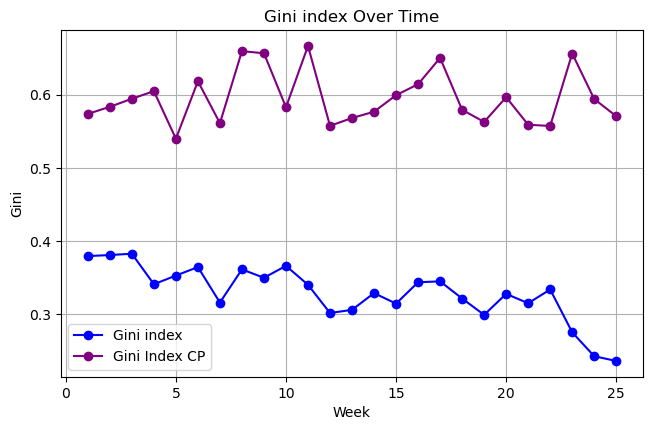

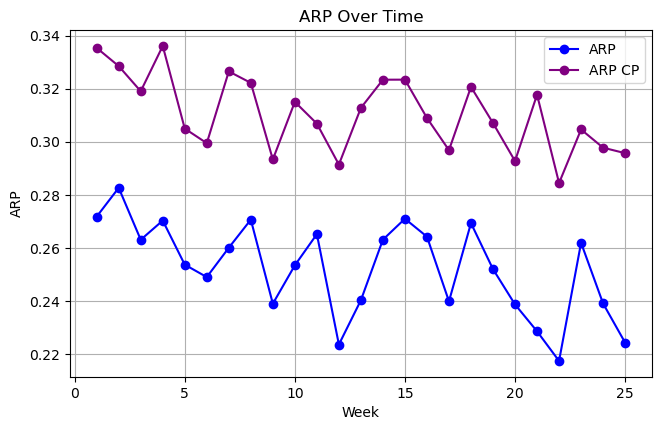

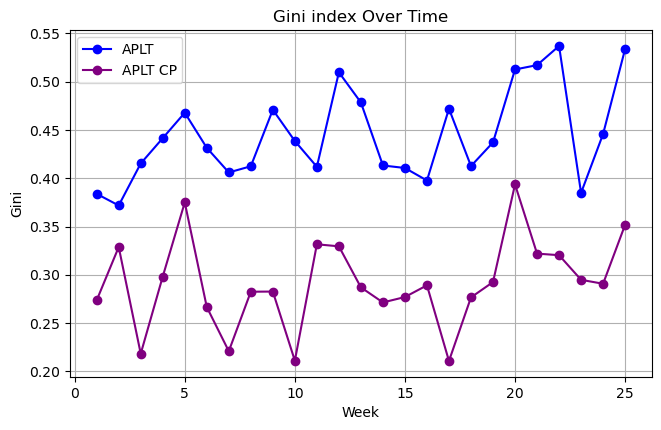

In [30]:
#Gini
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, gini_values, marker='o', color='b', label='Gini index')
plt.plot(results_df['week'], results_df['gini_index'], marker='o', color='purple', label='Gini Index CP')
plt.title('Gini index Over Time')
plt.xlabel('Week')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()

#arp
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, arp, marker='o', color='b', label='ARP')
plt.plot(results_df['week'], results_df['arp'], marker='o', color='purple', label='ARP CP')
plt.title('ARP Over Time')
plt.xlabel('Week')
plt.ylabel('ARP')
plt.grid(True)
plt.legend()
plt.show()

#Aplt
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, aplt, marker='o', color='b', label='APLT')
plt.plot(results_df['week'], results_df['aplt'], marker='o', color='purple', label='APLT CP')
plt.title('Gini index Over Time')
plt.xlabel('Week')
plt.ylabel('Gini')
plt.grid(True)
plt.legend()
plt.show()

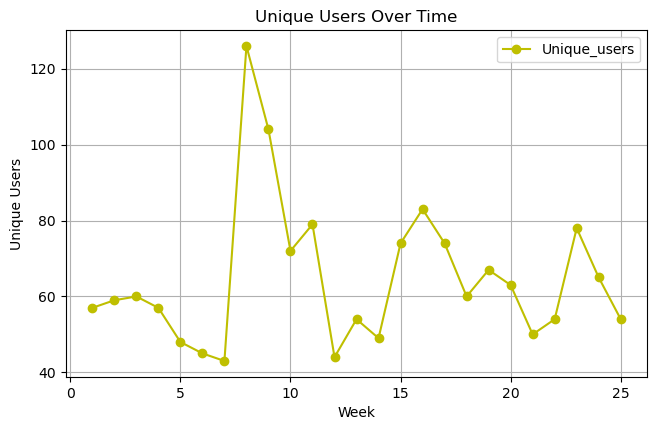

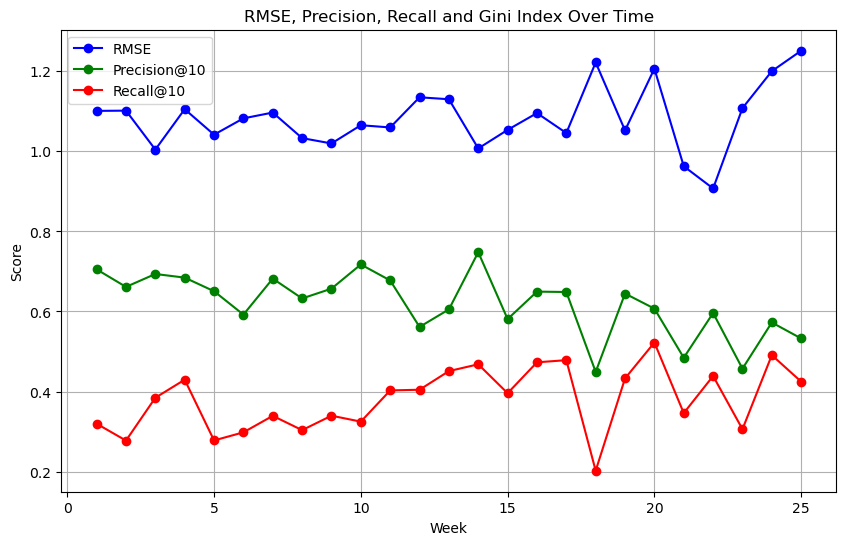

In [31]:
#Unique Users
plt.figure(figsize=(7.5, 4.5))
plt.plot(weeks, user_values, marker='o', color='y', label='Unique_users')
plt.title('Unique Users Over Time')
plt.xlabel('Week')
plt.ylabel('Unique Users')
plt.grid(True)
plt.legend()
plt.show()


#RMSE, Precision and Recall
plt.figure(figsize=(10, 6))
plt.plot(weeks, rmse_values, marker='o', color='b', label='RMSE')
plt.plot(weeks, precision_values, marker='o', color='g', label='Precision@10')
plt.plot(weeks, recall_values, marker='o', color='r', label='Recall@10')

plt.title('RMSE, Precision, Recall and Gini Index Over Time')
plt.xlabel('Week')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()